***Project Objective:***

The goal of this project is to understand the drivers of CO₂ emissions per capita across different countries and years by using various machine learning models. This approach helps identify the most impactful features and interpret how each input contributes to predictive accuracy. Ultimately, these insights aim to support forecasting progress toward carbon neutrality by highlighting key factors that influence emission trends and providing reliable models to predict when carbon neutrality targets might be achieved.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.base import clone
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/country-comparison-dataset-usa-and-more/country_comparison_large_dataset.csv


***Study Scope:***

This study focuses on 6 countries, which are USA, Russia, Canada, China, India and  Australia,  over the 2000–2023 period.
These were selected to represent a mix of:

* Developed vs. developing economies
* Energy profiles (renewables vs. fossil fuels)


In [2]:
data= pd.read_csv("/kaggle/input/country-comparison-dataset-usa-and-more/country_comparison_large_dataset.csv")
selected_columns = [
    'Country',
    'Year',
    'CO2 Emissions (Million Metric Tons)',
    'Energy Consumption (TWh)',
    'Renewable Energy Share (%)',
    'GDP per Capita (in USD)',
    'Population (in Millions)',
    'Corruption Perception Index',
    'Freedom of Press Index',
    'Human Development Index (HDI)'
]


df = data[selected_columns]
df['CO2 Emissions per Capita (Metric Tons)'] = df['CO2 Emissions (Million Metric Tons)'] / df['Population (in Millions)']
df['Energy Efficiency (GDP per Capita per TWh)'] = df['GDP per Capita (in USD)'] / df['Energy Consumption (TWh)']

df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Country,Year,CO2 Emissions (Million Metric Tons),Energy Consumption (TWh),Renewable Energy Share (%),GDP per Capita (in USD),Population (in Millions),Corruption Perception Index,Freedom of Press Index,Human Development Index (HDI),CO2 Emissions per Capita (Metric Tons),Energy Efficiency (GDP per Capita per TWh)
0,USA,2000,5156.10,4095.0,17.31,65455.0,330.34,67.41,45.27,0.97,15.608464,15.984127
1,Russia,2000,1660.80,1058.4,18.60,10923.0,141.81,30.90,146.10,0.85,11.711445,10.320295
2,Canada,2000,516.78,559.9,68.81,47932.0,36.63,74.74,16.42,0.96,14.108108,85.608144
3,China,2000,9690.00,6698.0,28.94,10060.0,1446.93,41.75,185.32,0.72,6.696938,1.501941
4,India,2000,2443.20,1500.0,11.50,2102.1,1313.76,40.12,136.36,0.67,1.859700,1.401400


***Features***


* CO2 Emissions per Capita (Metric Tons): CO₂ emissions divided by population. It allows comparison of individual environmental footprints
* Energy Efficiency (GDP per Capita per TWh): GDP per capita divided by energy consumption. Proxy for energy productivity, how efficiently a country converts energy into economic output
* Corruption Perception Index: Governance quality, which may influence energy and climate policies
* Renewable Energy Share (%): Percentage of energy from renewable sources
* Population (in Millions): Count of population in millions


In [3]:
# List of columns including target and features
cols = ['CO2 Emissions per Capita (Metric Tons)'] + [
    'Energy Efficiency (GDP per Capita per TWh)',
    'Corruption Perception Index',
    'Renewable Energy Share (%)',
    'Population (in Millions)'
]

# Subset the data
subset_data = df[cols]

# Get descriptive statistics
descriptive_stats = subset_data.describe().T

# Display with formatting (e.g., 2 decimals)
styled_table = descriptive_stats.style.format("{:.2f}")

# If you're in a notebook environment
display(styled_table)

,count,mean,std,min,25%,50%,75%,max
CO2 Emissions per Capita (Metric Tons),144.00,11.11,5.26,1.59,7.16,12.68,15.58,17.47
Energy Efficiency (GDP per Capita per TWh),144.00,48.15,64.29,1.33,1.50,13.02,82.78,188.11
Corruption Perception Index,144.00,55.24,18.66,28.56,40.07,54.82,73.41,80.85
Renewable Energy Share (%),144.00,27.90,18.49,11.41,17.15,20.86,29.31,70.15
Population (in Millions),144.00,550.91,600.17,23.90,37.34,233.77,1341.54,1462.31


The average CO2 emissions per capita is 11.11 metric tons, with notable variation across countries. Energy efficiency varies widely, with a few countries showing very high GDP output per energy consumed. Corruption perception scores and renewable energy shares also differ significantly, reflecting diverse governance and energy policies. Population sizes range greatly, skewed by highly populous countries like China and India.

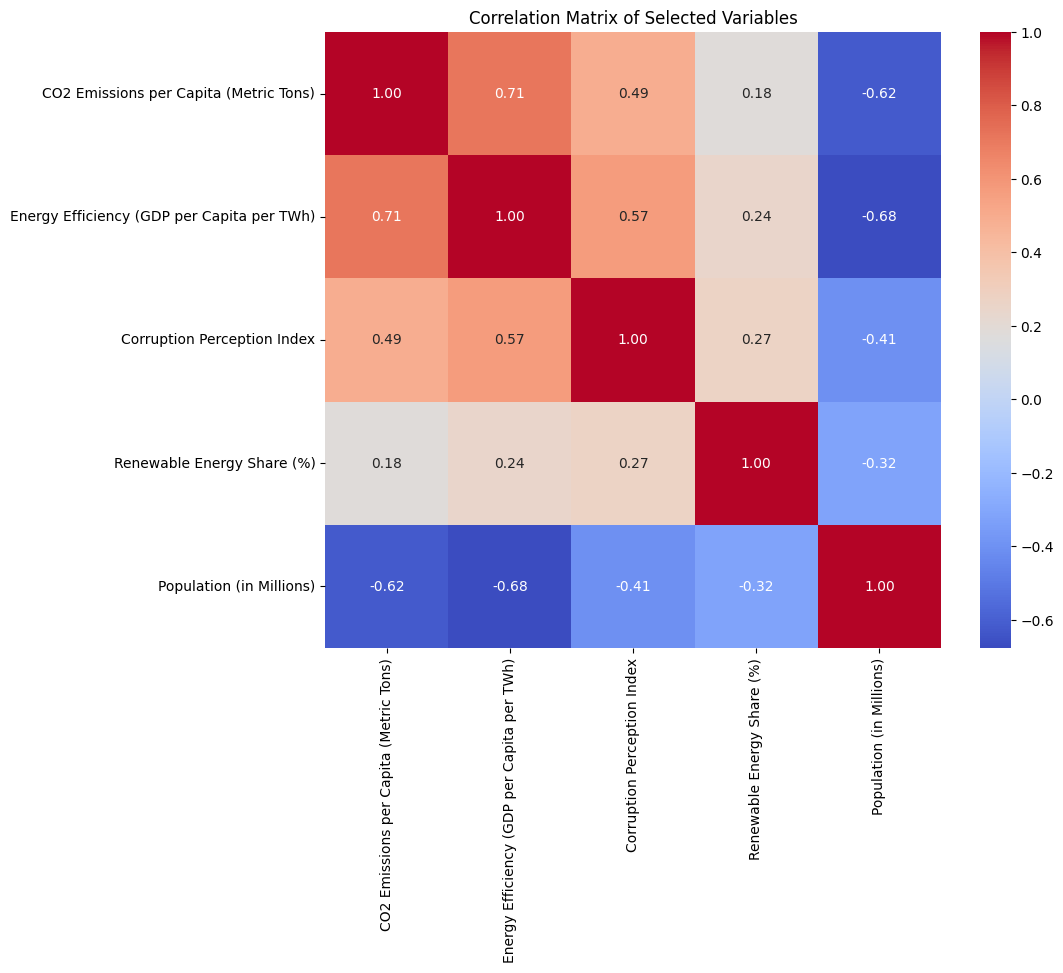

In [4]:
# Kendall Correlation Index
kendall_corr = subset_data.corr(method='kendall')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix of Selected Variables')
plt.show()


# ***Model Building***

# **1. Lasso Regression**

In [5]:
target = 'CO2 Emissions per Capita (Metric Tons)'
features = [
    'Energy Efficiency (GDP per Capita per TWh)',
    'Renewable Energy Share (%)',
    'Population (in Millions)',
    'Corruption Perception Index'
]

X = df[features]
y = df[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build model
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# Predict
y_pred = lasso_cv.predict(X_test)

# Evaluation
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_r2 = r2_score(y_test, y_pred)
lasso_mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Best Alpha from CV: {lasso_cv.alpha_:.4f}")
print(f"MAE: {lasso_mae:.4f}")
print(f"RMSE: {lasso_rmse:.4f}")
print(f"MAPE: {lasso_mape:.4f}")
print(f"R²: {lasso_r2:.4f}")

Best Alpha from CV: 0.0046
MAE: 1.3830
RMSE: 1.8206
MAPE: 0.3985
R²: 0.8799


# **2. Elastic Net Regression**

In [6]:
# Define features and target
X = df[features]
y = df[target]

# Initialize ElasticNetCV with 5-fold CV and random state for reproducibility
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)

# Fit model
elastic_net_cv.fit(X, y)

# Predict on training data (or use a test set if you have one)
y_pred = elastic_net_cv.predict(X)

# Evaluation metrics
en_mae = mean_absolute_error(y, y_pred)
en_rmse = np.sqrt(mean_squared_error(y, y_pred))
en_mape = np.mean(np.abs((y - y_pred) / y))  # MAPE calculation
en_r2 = r2_score(y, y_pred)

print(f"Best Alpha from CV: {elastic_net_cv.alpha_:.4f}")
print(f"Best L1 ratio (mixing parameter): {elastic_net_cv.l1_ratio_:.4f}")
print(f"MAE: {en_mae:.4f}")
print(f"RMSE: {en_rmse:.4f}")
print(f"MAPE: {en_mape:.4f}")
print(f"R²: {en_r2:.4f}")

Best Alpha from CV: 5.5605
Best L1 ratio (mixing parameter): 0.5000
MAE: 1.5012
RMSE: 1.8098
MAPE: 0.3733
R²: 0.8810


# **3. Decision Tree regression**

In [7]:
# Define your target and features
target = 'CO2 Emissions per Capita (Metric Tons)'
features = [
    'Energy Efficiency (GDP per Capita per TWh)',
    'Renewable Energy Share (%)',
    'Population (in Millions)',
    'Corruption Perception Index'
]

# Split the data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)  # you can tune max_depth
tree.fit(X_train, y_train)

# Predictions
y_pred = tree.predict(X_test)

# Evaluation
dt_mae = mean_absolute_error(y_test, y_pred)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
dt_mape = mean_absolute_percentage_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)

# Output the results
print(f"🌳 Decision Tree Regressor Results")
print(f"MAE: {dt_mae:.4f}")
print(f"RMSE: {dt_rmse:.4f}")
print(f"MAPE: {dt_mape:.4f}")
print(f"R²: {dt_r2:.4f}")


🌳 Decision Tree Regressor Results
MAE: 0.3156
RMSE: 0.4098
MAPE: 0.0333
R²: 0.9939


# **4. Random Forest regression**

In [8]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit model
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression Results:")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAPE: {mape_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

Random Forest Regression Results:
MAE: 0.2815
RMSE: 0.3662
MAPE: 0.0282
R²: 0.9951


# **5. XG Boost Regression**

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you already have X_train, X_test, y_train, y_test

# Initialize XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # for regression
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

# Fit the model
xgb_reg.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_reg.predict(X_test)

# Calculate metrics
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = mean_squared_error(y_test, y_pred, squared=False)
xgb_mape = np.mean(np.abs((y_test - y_pred) / y_test))
xgb_r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression Results:")
print(f"MAE: {xgb_mae:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAPE: {xgb_mape:.4f}")
print(f"R²: {xgb_r2:.4f}")

XGBoost Regression Results:
MAE: 0.5235
RMSE: 0.6979
MAPE: 0.0656
R²: 0.9824


In [10]:
# Initialize AdaBoost Regressor
ada = AdaBoostRegressor(random_state=42)

# Fit model
ada.fit(X_train, y_train)

# Predict
y_pred_ada = ada.predict(X_test)

# Evaluate
ada_mae = mean_absolute_error(y_test, y_pred_ada)
ada_rmse = mean_squared_error(y_test, y_pred_ada, squared=False)
ada_mape = mean_absolute_percentage_error(y_test, y_pred_ada)
ada_r2 = r2_score(y_test, y_pred_ada)

print(f"AdaBoost Regression Results:")
print(f"MAE: {ada_mae:.4f}")
print(f"RMSE: {ada_rmse:.4f}")
print(f"MAPE: {ada_mape:.4f}")
print(f"R²: {ada_r2:.4f}")

AdaBoost Regression Results:
MAE: 0.2821
RMSE: 0.3698
MAPE: 0.0288
R²: 0.9950


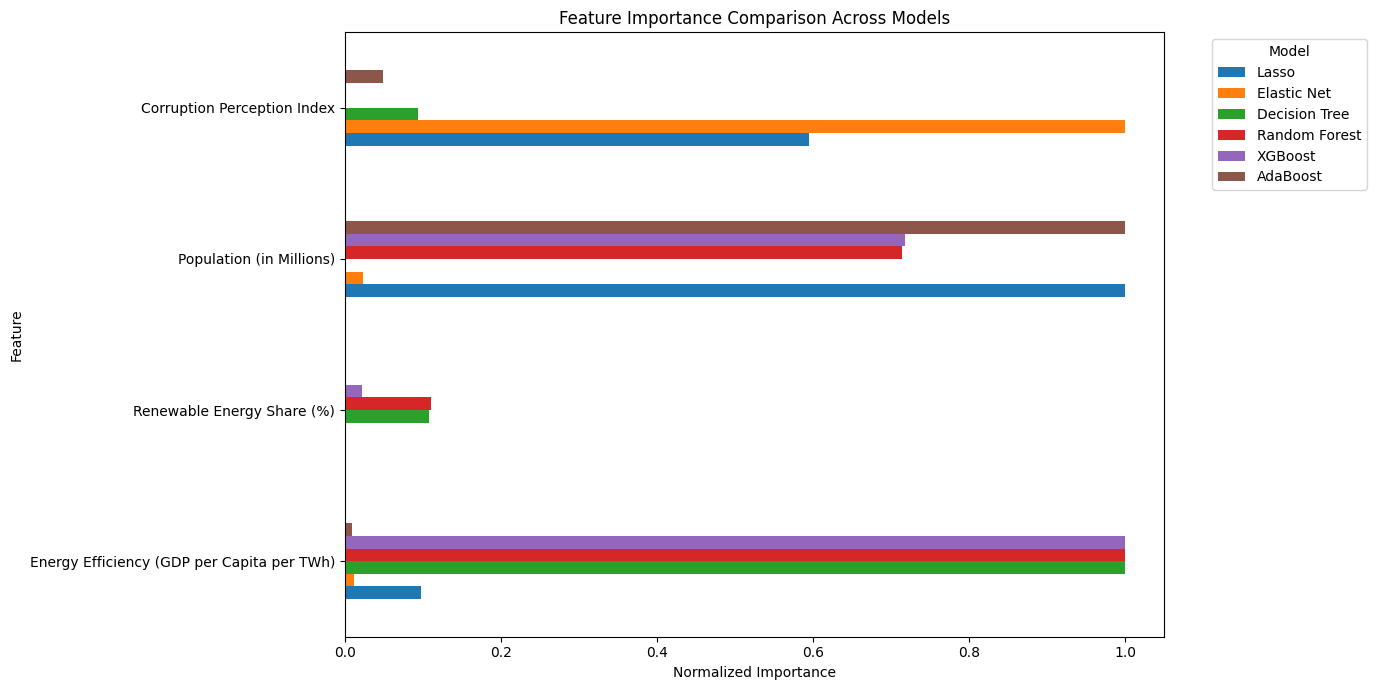

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize(arr):
    arr = np.abs(arr).reshape(-1, 1)  # abs for regression coefficients
    return MinMaxScaler().fit_transform(arr).flatten()

# Linear models: use coefficients
lasso_imp   = normalize(lasso_cv.coef_)
elastic_imp = normalize(elastic_net_cv.coef_)

# Tree models: use feature_importances_
dt_imp  = normalize(tree.feature_importances_)
rf_imp  = normalize(rf.feature_importances_)
xgb_imp = normalize(xgb_reg.feature_importances_)
ada_imp = normalize(ada.feature_importances_)


importance_df = pd.DataFrame({
    'Feature': features,
    'Lasso': lasso_imp,
    'Elastic Net': elastic_imp,
    'Decision Tree': dt_imp,
    'Random Forest': rf_imp,
    'XGBoost': xgb_imp,
    'AdaBoost': ada_imp
})

importance_df.set_index('Feature', inplace=True)

importance_df.plot(kind='barh', figsize=(14, 7))
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
importance_df.head(100)

,Lasso,Elastic Net,Decision Tree,Random Forest,XGBoost,AdaBoost
Feature,,,,,,
Energy Efficiency (GDP per Capita per TWh),0.097592,0.011640,1.000000,1.000000,1.000000,0.009018
Renewable Energy Share (%),0.000000,0.000000,0.108208,0.110219,0.022414,0.000000
Population (in Millions),1.000000,0.023674,0.000000,0.713892,0.717781,1.000000
Corruption Perception Index,0.594620,1.000000,0.093658,0.000000,0.000000,0.048523


Measuring Features importances among different models showed:

* **Population (in Millions**) is the most important predictor for the Lasso, Random Forest, XGBoost, and AdaBoost models, indicating that the size of the population strongly influences per capita CO2 emissions in these models.

* **Energy Efficiency (GDP per Capita per TWh)** is the key feature for the Decision Tree and Random Forest models, showing these tree-based methods heavily rely on how efficiently energy is used economically to explain CO2 emissions per capita.

* **Corruption Perception Index** plays a major role in the Elastic Net and Lasso models but is less important for the tree-based models, suggesting governance quality is influential in linear models but less so in nonlinear ones.

* **Renewable Energy Share (%)** has relatively low importance across all models, implying that within this dataset and timeframe, the share of renewable energy has a weaker direct impact on predicting CO2 emissions per capita compared to other factors.

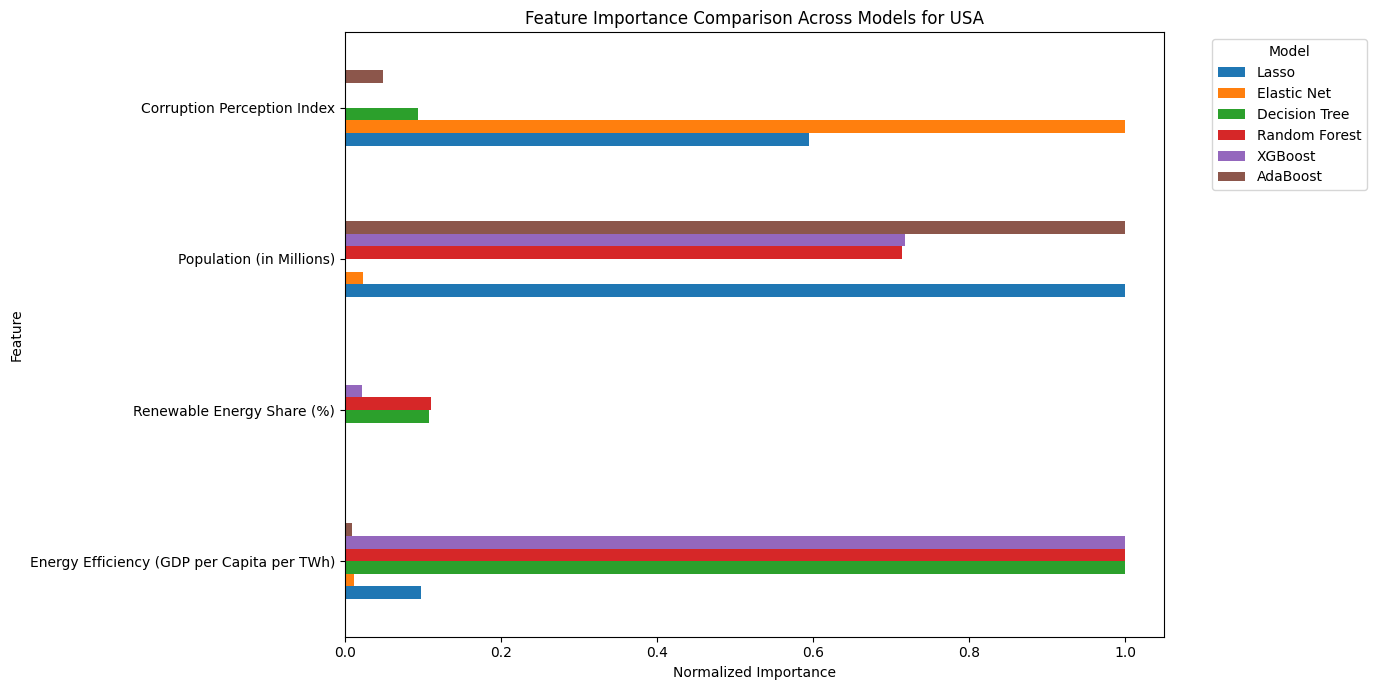

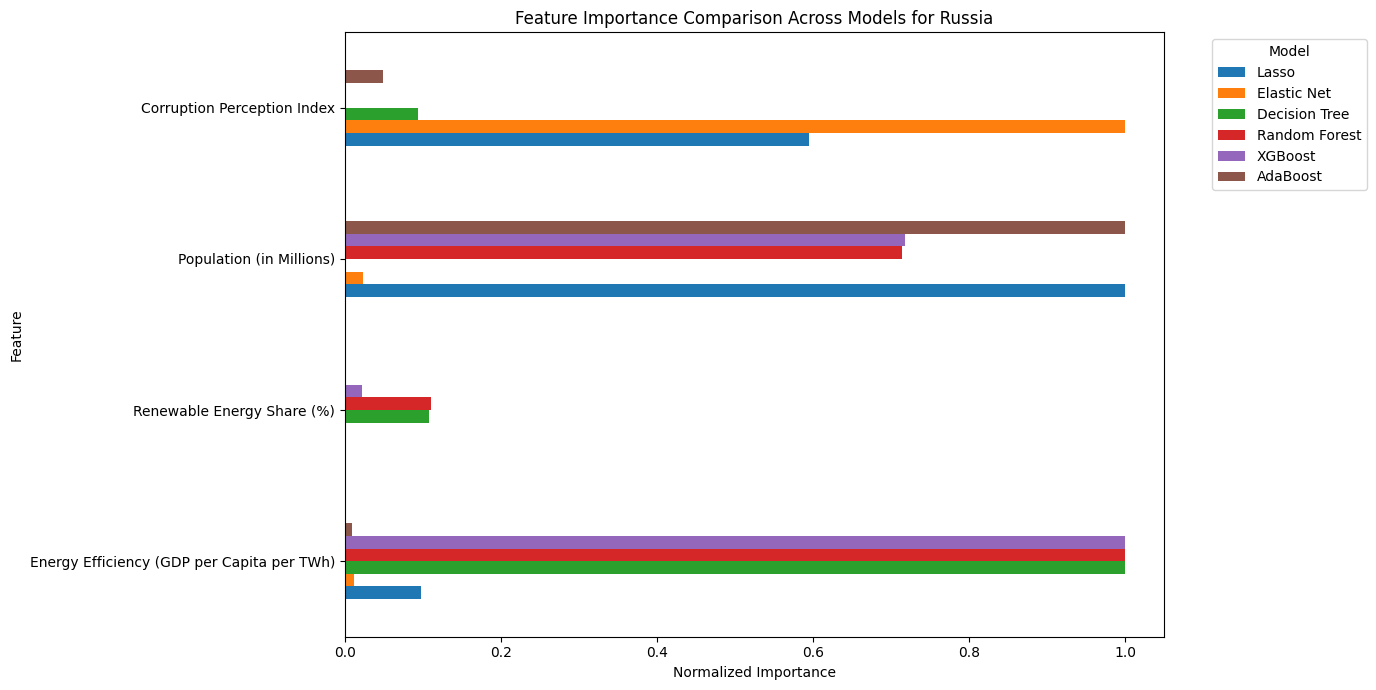

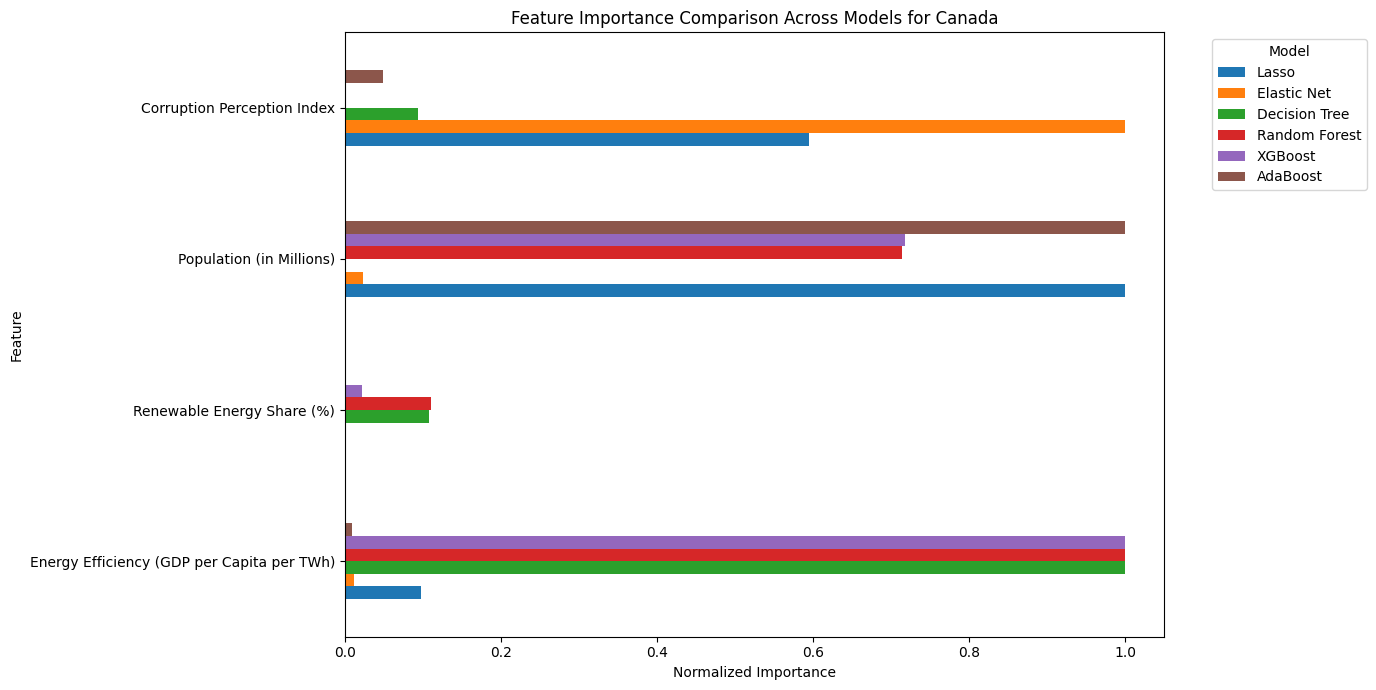

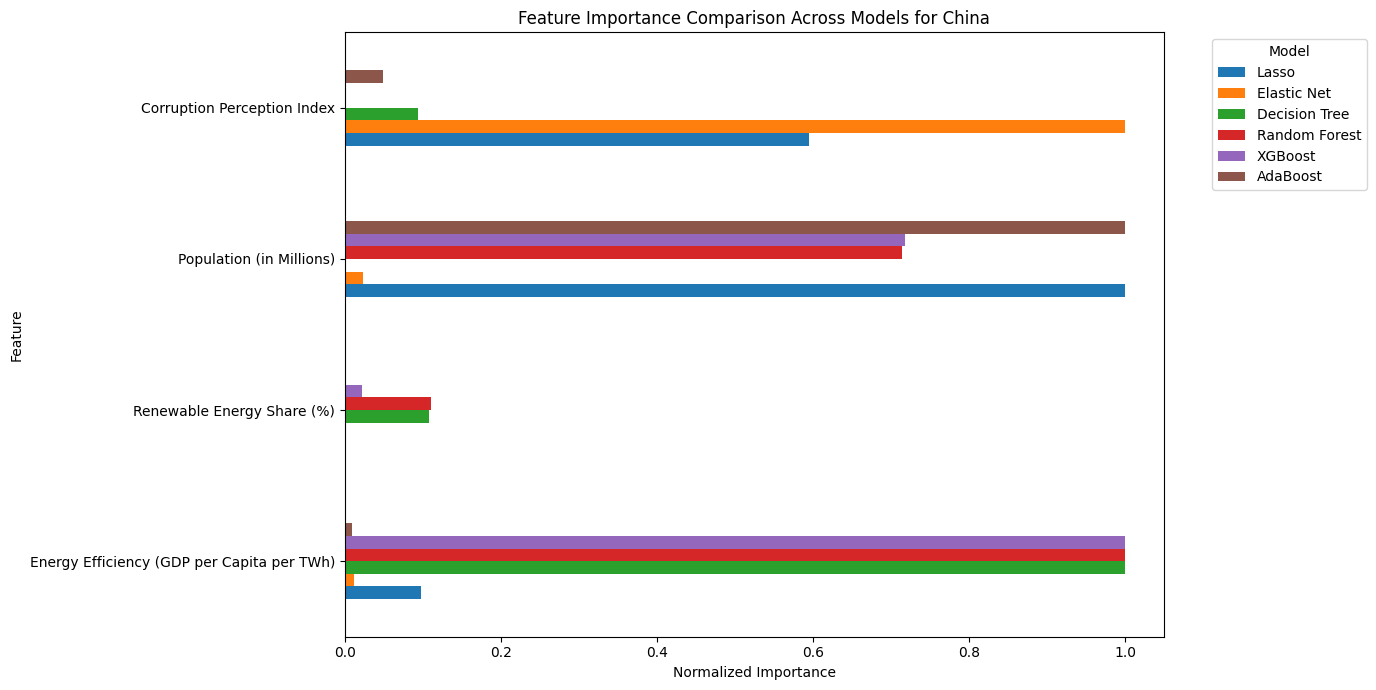

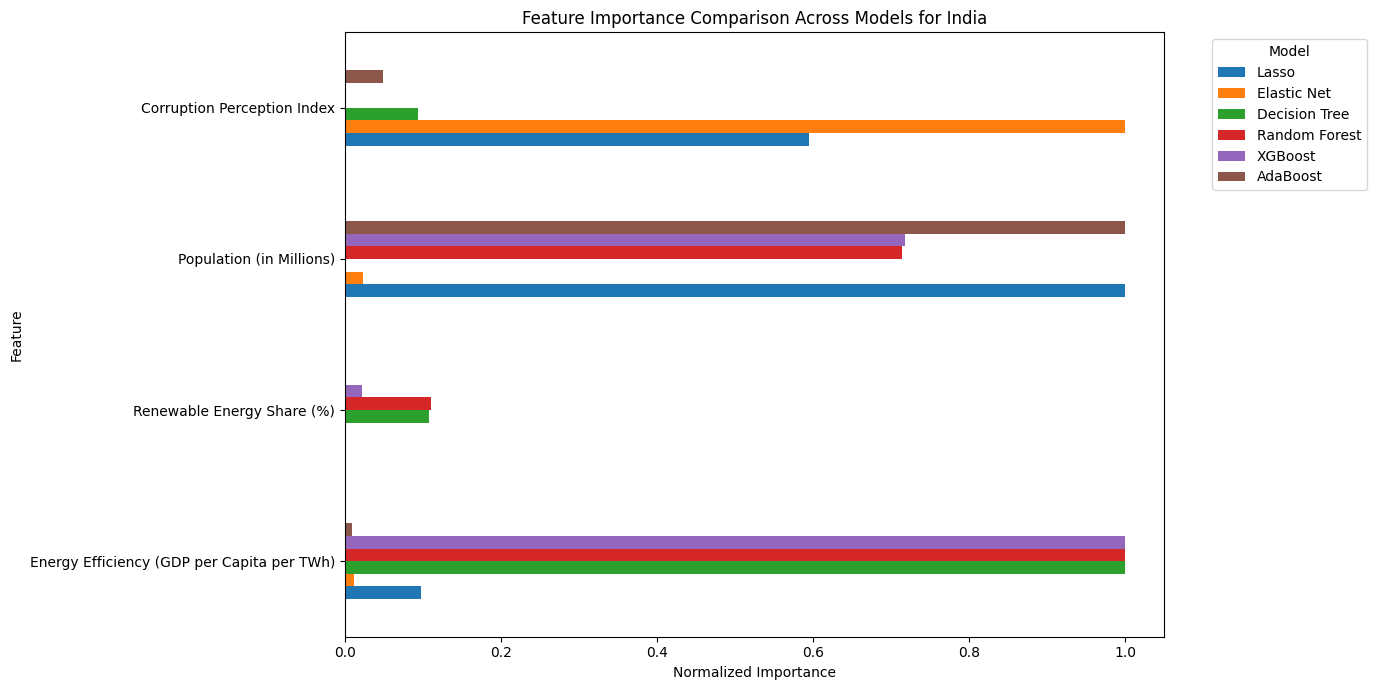

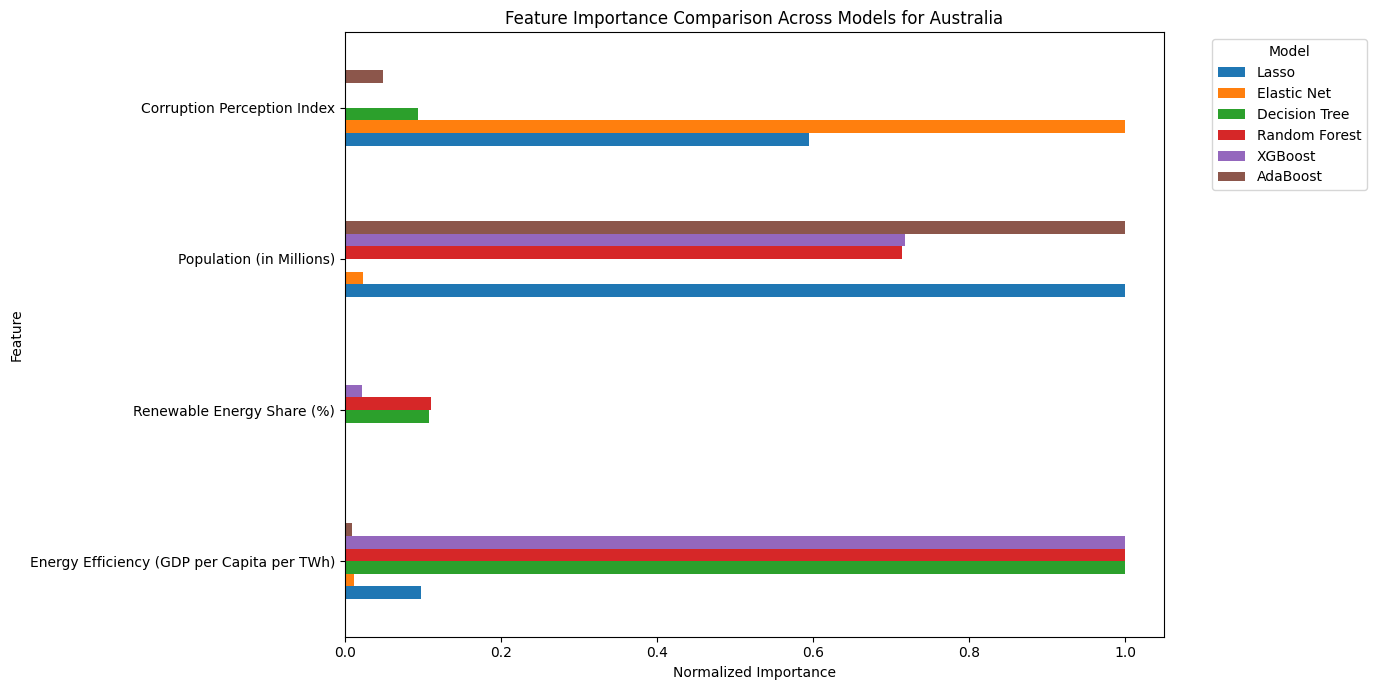

In [13]:
def normalize(arr):
    arr = np.abs(arr).reshape(-1, 1)  # absolute value for regression coefficients
    return MinMaxScaler().fit_transform(arr).flatten()

lasso_imp   = normalize(lasso_cv.coef_)
elastic_imp = normalize(elastic_net_cv.coef_)
dt_imp  = normalize(tree.feature_importances_)
rf_imp  = normalize(rf.feature_importances_)
xgb_imp = normalize(xgb_reg.feature_importances_)
ada_imp = normalize(ada.feature_importances_)


countries = df['Country'].unique()
rows = []

for country in countries:
    for i, feature in enumerate(features):
        rows.append({
            'Country': country,
            'Feature': feature,
            'Lasso': lasso_imp[i],
            'Elastic Net': elastic_imp[i],
            'Decision Tree': dt_imp[i],
            'Random Forest': rf_imp[i],
            'XGBoost': xgb_imp[i],
            'AdaBoost': ada_imp[i]
        })

importance_df = pd.DataFrame(rows)

# --- Plot feature importance comparison for each country ---

for country in importance_df['Country'].unique():
    country_df = importance_df[importance_df['Country'] == country]
    plot_df = country_df.set_index('Feature').drop(columns=['Country'])
    
    plot_df.plot(kind='barh', figsize=(14, 7))
    plt.title(f'Feature Importance Comparison Across Models for {country}')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


The feature importance patterns are consistent across all six countries (USA, Russia, Canada, China, India, Australia) and models, indicating stable relationships between features and CO₂ emissions per capita regardless of country.

However, differences emerge when considering the relative importance of features by country:

* For USA, Canada, and Australia (developed economies with moderate populations), Population is strongly important in most models, but Energy Efficiency also plays a major role, reflecting these countries’ emphasis on economic productivity relative to energy use.

* In China and India, with very large populations, Population overwhelmingly dominates the importance scores, highlighting population size as the primary driver of per capita emissions in these emerging economies.

* Russia shows a more balanced importance between Population and Energy Efficiency, possibly reflecting its unique energy profile with both resource-intensive industries and large population.

* The Corruption Perception Index tends to have more influence in linear models (Lasso, Elastic Net) across all countries but generally remains less important in tree-based models, suggesting governance impacts are nuanced and might affect emissions indirectly.


# ***Performance indicators for each model***

In [14]:
metrics_data = {
    'Lasso': [lasso_mae, lasso_rmse, lasso_mape, lasso_r2],
    'Elastic Net': [en_mae, en_rmse, en_mape, en_r2],
    'Decision Tree': [dt_mae, dt_rmse, dt_mape, dt_r2],
    'Random Forest': [mae_rf, rmse_rf, mape_rf, r2_rf],
    'XGBoost': [xgb_mae, xgb_rmse, xgb_mape, xgb_r2],
    'AdaBoost': [ada_mae, ada_rmse, ada_mape, ada_r2]
}

metrics_index = ['MAE', 'RMSE', 'MAPE', 'R²']

metrics_df = pd.DataFrame(metrics_data, index=metrics_index)
metrics_df = metrics_df.T
metrics_df.head(10)

,MAE,RMSE,MAPE,R²
Lasso,1.383002,1.820560,0.398520,0.879916
Elastic Net,1.501155,1.809763,0.373287,0.880988
Decision Tree,0.315648,0.409762,0.033289,0.993917
Random Forest,0.281513,0.366184,0.028180,0.995142
XGBoost,0.523461,0.697888,0.065647,0.982354
AdaBoost,0.282143,0.369793,0.028800,0.995046


The tree-based models (Decision Tree, Random Forest, AdaBoost, and XGBoost) *outperform the linear models (Lasso and Elastic Net) across all metrics.* **Random Forest** **achieves the best overall accuracy, with the lowest MAE (0.28), RMSE (0.37), and MAPE (2.8%), and the highest R² (0.995), indicating excellent predictive power.** Decision Tree and AdaBoost follow closely, showing similarly strong performance. In contrast, Lasso and Elastic Net have higher errors and lower R² (~0.88), reflecting less precise predictions. This suggests that non-linear models better capture the complex relationships affecting CO₂ emissions per capita.

# **1. SHAP**

In [15]:
X = X_train  
# Decision Tree SHAP
explainer_dt = shap.Explainer(tree.predict, X)
shap_values_dt = explainer_dt(X)

# Random Forest SHAP
explainer_rf = shap.Explainer(rf.predict, X)
shap_values_rf = explainer_rf(X)

# XGBoost SHAP
explainer_xgb = shap.Explainer(xgb_reg.predict, X)
shap_values_xgb = explainer_xgb(X)

# AdaBoost regression SHAP
explainer_ada = shap.Explainer(ada.predict, X)
shap_values_ada = explainer_ada(X)

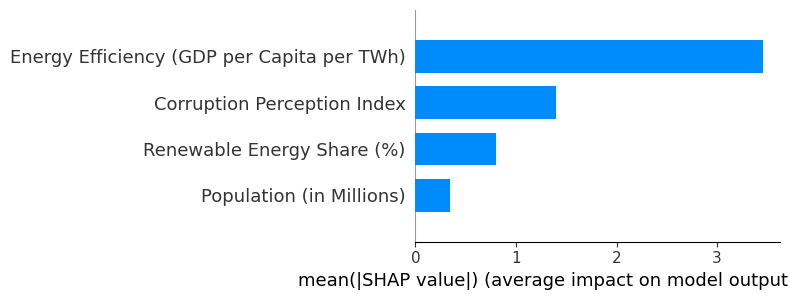

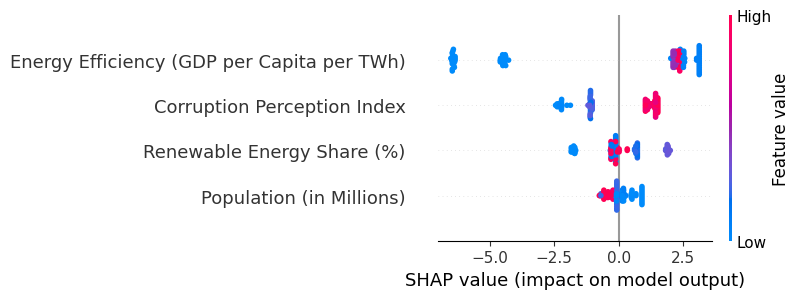

In [16]:
# Decision Tree
shap.summary_plot(shap_values_dt, X, plot_type="bar", show=True)
shap.summary_plot(shap_values_dt, X, show=True)

* **Energy Efficiency** is the most powerful predictor: it shifts model outputs by almost ±4 units on average. Its average impact is +0.38, meaning higher efficiency is associated with higher predictions, possibly indicating better performance or development.

* **Corruption Perception Index** has a consistent negative impact: less corruption reduces the prediction by ~0.37 units per index point — maybe because your target favors more interventionist or less liberal markets.

* **Renewable Energy Share and Populatio**n are relatively weak predictors. While renewables slightly boost the prediction, the standard deviation (1.08) is much larger than the average effect (0.07), meaning it's not consistently influential.

* **Population** has minimal predictive power in your model (±0.30 SHAP value, and mean effect of just –0.08).



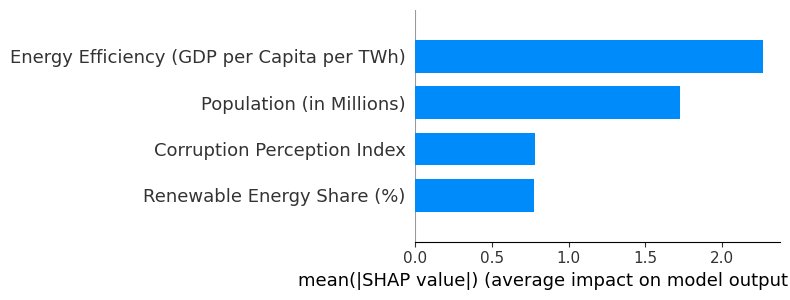

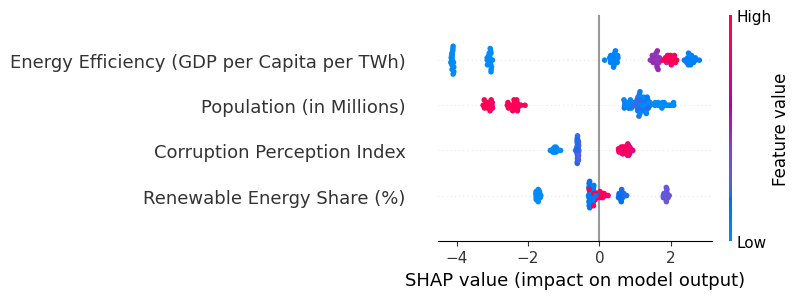

In [17]:
# Random Forest
shap.summary_plot(shap_values_rf, X, plot_type="bar", show=True)
shap.summary_plot(shap_values_rf, X, show=True)

* **Energy Efficiency** is still the most influential, *but it now shows a weaker and more inconsistent directional effect compared to the previous model (mean SHAP: +0.11 vs. +0.38 in Decision Tree)*. It may be used in nonlinear or conditional splits across many trees.

* **Population** *became much more important* (±1.84 SHAP vs. ±0.30 before) and now shows a positive influence — higher population tends to increase the prediction, though inconsistently (std: 1.96).

* **Corruption Index** impact weakened. Although still negative, it is less influential and shows lower deviation.

* **Renewable Share** remains marginal , it has a very low mean SHAP and moderate variability.



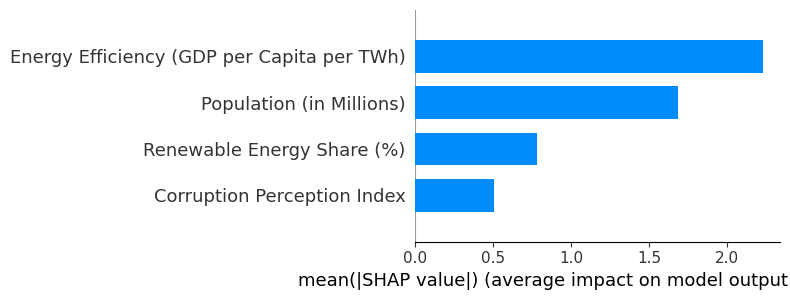

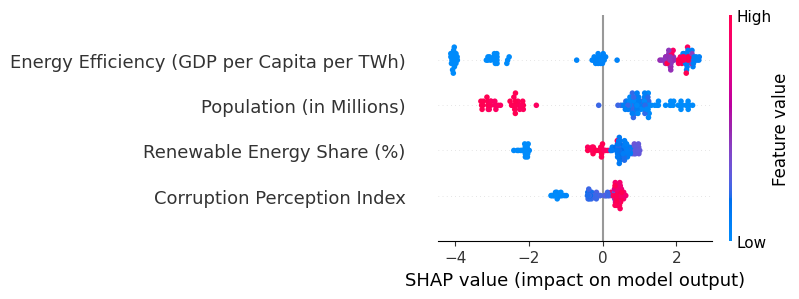

In [18]:
# XGBoost
shap.summary_plot(shap_values_xgb, X, plot_type="bar", show=True)
shap.summary_plot(shap_values_xgb, X, show=True)

* **Energy Efficiency** remains the most important feature in XGBoost, *but has very high variance (std: 2.78)*. This suggests it plays a strong but complex role — sometimes increasing, sometimes decreasing the prediction depending on interactions.

* **Population** is the second most influential. Interestingly, it shows a slightly negative mean SHAP (–0.18) despite being heavily used. *This could mean that larger populations are associated with slightly lower predictions, on average.*

* **Renewable Share** is the only feature with a **consistently positive mean SHAP** (+0.24), indicating that *greater renewable energy share is beneficial for the target outcome.*

* **Corruption Index** has the lowest contribution and variability, making it the least impactful and most stable feature.

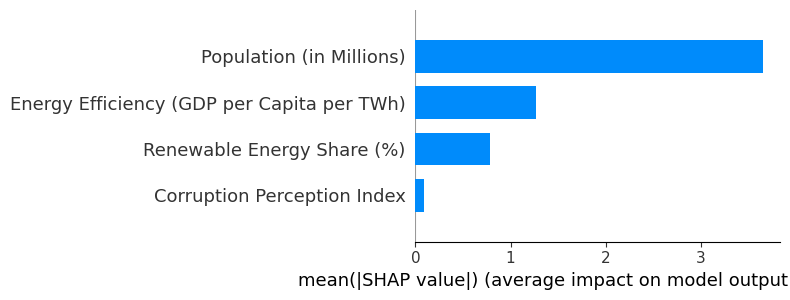

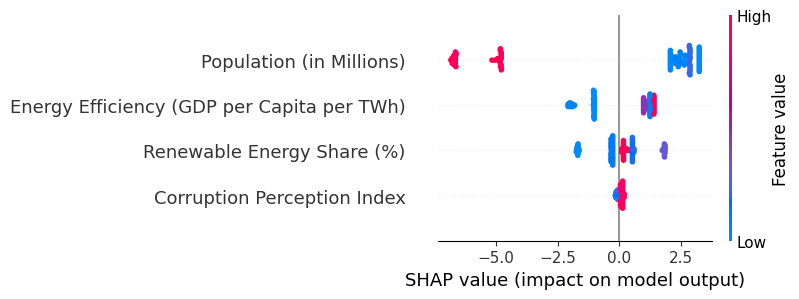

In [19]:
# AdaBoost
shap.summary_plot(shap_values_ada, X, plot_type="bar", show=True)
shap.summary_plot(shap_values_ada, X, show=True)

* **Population (in Millions)** has the highest average impact on model predictions with a mean absolute SHAP value of 3.65, *indicating it is the most influential feature in this model.*

       - The mean SHAP value is -0.08, very close to zero, with a large standard deviation (3.99), suggesting the feature’s effect on predictions varies significantly across samples — sometimes increasing and sometimes decreasing the output.

* **Energy Efficiency (GDP per Capita per TWh)** is the second most important feature with a mean absolute SHAP value of 1.27.

      - It has a slightly negative average effect (-0.04) and moderate variability (std = 1.32), indicating it generally pushes predictions downward but with some variability.


* **Renewable Energy Share (%)** contributes less (mean absolute SHAP 0.79), with a small positive average effect (0.03) and moderate variation (std = 1.04). This suggests it tends to increase the model output but not strongly or consistently.

* **Corruption Perception Index** has minimal influence on the model with a very low mean absolute SHAP value of 0.09.

      - Its mean effect is near zero (-0.0035) and very low variability (0.10), implying this feature rarely changes predictions.


**=>** The model is mostly *driven by Population, which shows a wide range of influence on predictions, both positive and negative.* Energy Efficiency and Renewable Energy Share have smaller but noticeable effects, while Corruption Perception Index plays a negligible role.

In [20]:
X_train = X_train.copy()
X_train['Country'] = df.loc[X_train.index, 'Country']

#  Prepare feature set by dropping 'Country' (non-numeric)
X_features = X_train.drop(columns=['Country'])

X_features_reset = X_features.reset_index(drop=True)
countries_reset = X_train['Country'].reset_index(drop=True)

#Compute SHAP values for each model

# Decision Tree
explainer_dt = shap.TreeExplainer(tree)
shap_values_dt = explainer_dt.shap_values(X_features_reset)

# Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_features_reset)

# XGBoost
explainer_xgb = shap.TreeExplainer(xgb_reg)
shap_values_xgb = explainer_xgb.shap_values(X_features_reset)

# AdaBoost: use shap.Explainer
explainer_ada = shap.Explainer(ada.predict, X_features_reset)
shap_values_ada = explainer_ada(X_features_reset)

# 4. Visualize Local SHAP Force plots for first observation of each country
shap.initjs()

for country in countries_reset.unique():
    # Get first index of this country
    idx = countries_reset[countries_reset == country].index[0]
    row = X_features_reset.iloc[idx]

    print(f"Country: {country} | Observation index (reset): {idx}\n")

    print(f"Decision Tree SHAP Force Plot for {country}")
    display(shap.force_plot(explainer_dt.expected_value, shap_values_dt[idx], row, matplotlib=False))

    print(f"Random Forest SHAP Force Plot for {country}")
    display(shap.force_plot(explainer_rf.expected_value, shap_values_rf[idx], row, matplotlib=False))

    print(f"XGBoost SHAP Force Plot for {country}")
    display(shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[idx], row, matplotlib=False))

    print(f"AdaBoost SHAP Force Plot for {country}")
    display(shap.force_plot(shap_values_ada.base_values[idx], shap_values_ada.values[idx], row, matplotlib=False))

    print("\n" + "-"*80 + "\n")


Country: India | Observation index (reset): 0

Decision Tree SHAP Force Plot for India


Random Forest SHAP Force Plot for India


XGBoost SHAP Force Plot for India


AdaBoost SHAP Force Plot for India



--------------------------------------------------------------------------------

Country: Russia | Observation index (reset): 1

Decision Tree SHAP Force Plot for Russia


Random Forest SHAP Force Plot for Russia


XGBoost SHAP Force Plot for Russia


AdaBoost SHAP Force Plot for Russia



--------------------------------------------------------------------------------

Country: Canada | Observation index (reset): 2

Decision Tree SHAP Force Plot for Canada


Random Forest SHAP Force Plot for Canada


XGBoost SHAP Force Plot for Canada


AdaBoost SHAP Force Plot for Canada



--------------------------------------------------------------------------------

Country: USA | Observation index (reset): 3

Decision Tree SHAP Force Plot for USA


Random Forest SHAP Force Plot for USA


XGBoost SHAP Force Plot for USA


AdaBoost SHAP Force Plot for USA



--------------------------------------------------------------------------------

Country: China | Observation index (reset): 6

Decision Tree SHAP Force Plot for China


Random Forest SHAP Force Plot for China


XGBoost SHAP Force Plot for China


AdaBoost SHAP Force Plot for China



--------------------------------------------------------------------------------

Country: Australia | Observation index (reset): 20

Decision Tree SHAP Force Plot for Australia


Random Forest SHAP Force Plot for Australia


XGBoost SHAP Force Plot for Australia


AdaBoost SHAP Force Plot for Australia



--------------------------------------------------------------------------------



In [21]:
results = []

# List of models and their SHAP values + expected values
models = {
    'Decision Tree': (explainer_dt.expected_value, shap_values_dt),
    'Random Forest': (explainer_rf.expected_value, shap_values_rf),
    'XGBoost': (explainer_xgb.expected_value, shap_values_xgb),
    'AdaBoost': (shap_values_ada.base_values, shap_values_ada.values)
}

# Loop over countries
for country in countries_reset.unique():
    idx = countries_reset[countries_reset == country].index[0]
    
    row_features = X_features_reset.iloc[idx]
    
    # Loop over models
    for model_name, (expected_value, shap_values) in models.items():
        # For AdaBoost shap_values is a shap.Explanation object
        if model_name == 'AdaBoost':
            shap_vals = shap_values[idx]
            base_val = expected_value[idx]
        else:
            shap_vals = shap_values[idx]
            base_val = expected_value
        
        # Prepare a dict of SHAP values per feature
        shap_dict = dict(zip(X_features_reset.columns, shap_vals))
        
        row_data = {'Country': country, 'Model': model_name, 'Expected_Value': base_val}
        row_data.update(shap_dict)
        
        results.append(row_data)


shap_country_df = pd.DataFrame(results)

# Show table
shap_country_df.head(1000)

,Country,Model,Expected_Value,Energy Efficiency (GDP per Capita per TWh),Renewable Energy Share (%),Population (in Millions),Corruption Perception Index
0,India,Decision Tree,[11.22774306653773],-6.462183,-1.653430,-0.344728,-1.085112
1,India,Random Forest,[11.146205570995221],-4.023561,-1.756950,-3.105048,-0.588542
2,India,XGBoost,11.178329,-4.601027,-1.510467,-3.298771,-0.136272
3,India,AdaBoost,11.276865,-1.035877,-1.748318,-6.728639,-0.075901
4,Russia,Decision Tree,[11.22774306653773],3.136184,-0.276135,-0.101593,-2.790868
5,Russia,Random Forest,[11.146205570995221],0.564675,-0.338386,1.166137,-1.536743
6,Russia,XGBoost,11.178329,-0.016211,0.421251,0.737318,-1.186501
7,Russia,AdaBoost,11.276865,-2.038767,-0.345101,2.284639,-0.142909
8,Canada,Decision Tree,[11.22774306653773],2.765747,-0.085488,0.029123,0.727781
9,Canada,Random Forest,[11.146205570995221],1.871149,0.065250,1.260754,0.395025


**1. India**

* Population (in Millions) has a negative impact on predicted CO2 emissions per capita.
→ ***This makes sense because India has a very large population but relatively low per capita emissions, so a larger population tends to dilute per capita emissions on average.***

* Energy Efficiency (GDP per Capita per TWh) and Renewable Energy Share (%) also negatively impact emissions, which means:
*→ Better energy efficiency and more renewables correlate with lower emissions per capita, as expected.*

* Corruption Perception Index is slightly negative, suggesting that perceived corruption may be linked to slightly lower CO2 emissions per capita, ***possibly because of underreporting or inefficient industrial activity.***

**2. Russia**

* Population has mixed effects; sometimes positive, sometimes negative. *Russia’s smaller population but heavy industrial base might cause mixed signals.*

* Energy Efficiency mostly increases emissions per capita, which could mean *energy efficiency is currently linked with heavy fossil fuel use or industrial activity in Russia,  somewhat counterintuitive but plausible if efficiency gains haven’t reduced emissions yet.*

* Renewable Energy Share is small or negative, indicating renewables might not yet significantly reduce emissions.

* Corruption Perception strongly decreases emissions per capita, possibly indicating governance issues impact emissions reporting or industrial activity.

**3. Canada**

* Population increases CO2 per capita slightly, reflecting energy use in remote and industrial regions.

* Energy Efficiency positively impacts emissions per capita, showing that 
*energy-intensive industries still dominating.*

* Renewable Energy Share positive but smaller effect, *showing increasing renewables hasn’t drastically reduced per capita emissions yet.*

* Corruption Perception positive effect suggests *better governance aligns with more reported emissions (more industrialized)*.

**4. USA**
   
* Population tends to increase CO2 per capita slightly, which is due to lifestyle, transport, and heavy industrial patterns.

* Energy Efficiency has a positive impact, which suggest *sectors where efficiency correlates with higher emissions (e.g., more industrial output).*

* Renewable Energy Share effect varies, but generally has some positive influence on emissions, reflecting the complexity of energy transition phases in USA.

* Corruption Perception increases emissions, consistent with developed country governance and transparency.

**5. China**

* Population strongly lowers CO2 emissions per capita, ***consistent with its huge population diluting average per capita emissions.***

* Energy Efficiency decreases emissions per capita, *reflecting successful efficiency gains reducing emissions intensity.*

* Renewable Energy Share strongly increases emissions per capita , ***reflecting China policy in  expanding in renewables, it’s also rapidly industrializing and fossil fuel use grows in parallel, temporarily boosting per capita emissions.***

* Corruption Perception has little consistent impact.

**6. Australia**

* All features positively influence CO2 emissions per capita.
→ Australia’s smaller population but high energy use and fossil fuel dependence make all these features push emissions up.

* Good governance (lower corruption) aligns with more accurate, higher emissions reporting.

**SUMMARY**

1. **Population (in Millions):**

For highly populous countries like India and China, an increase in population tends to reduce CO2 emissions per capita because total emissions are spread over many people, lowering the per capita average.

For countries with smaller or moderate populations like Canada, USA, Russia, and Australia, population changes tend to have a positive or mixed effect, reflecting the impact of population on per capita emissions driven by industrial and lifestyle factors.

2. **Energy Efficiency (GDP per Capita per TWh):**

Generally, better energy efficiency correlates with lower CO2 emissions per capita in countries like India and China, indicating effective energy use reduces emissions intensity.

In some developed or resource-heavy economies like Canada, USA, and Russia, higher energy efficiency sometimes relates to higher emissions per capita, which might reflect ongoing industrial activity where efficiency gains coexist with high energy consumption.

3. **Renewable Energy Share (%):**

Increasing renewable energy share is mostly associated with reduced emissions per capita or a small negative effect in countries such as India and Australia, showing the positive impact of clean energy.

*In China and some developed countries, a higher renewable share surprisingly correlates with increased emissions per capita, likely because renewables are growing alongside expanding industrial production and fossil fuel use during energy transition phases.*

4. **Corruption Perception Index:**

The effect of governance and corruption perceptions varies across countries. In some cases (e.g., Russia), higher corruption perception aligns with lower reported emissions, potentially due to underreporting or inefficiencies.

In others (e.g., Canada, USA), better governance correlates with higher emissions per capita, possibly 
*reflecting more transparent and comprehensive emissions reporting.*

**This overall picture highlights the complexity of factors affecting CO2 emissions per capita, reflecting differences in population size, economic structure, energy policies, and governance across countries.**

# **2. Sensitivity Analysis Function**


=== 🔍 Sensitivity Analysis: Lasso ===
🔹 Base Performance — RMSE: 1.8085 | MAE: 1.4527 | R²: 0.8815



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
2,Population (in Millions),1.631934,1.155994,-0.310352
3,Corruption Perception Index,0.569327,0.645690,-0.086353
0,Energy Efficiency (GDP per Capita per TWh),0.030997,0.023422,-0.004097
1,Renewable Energy Share (%),-0.000561,0.047000,0.000073


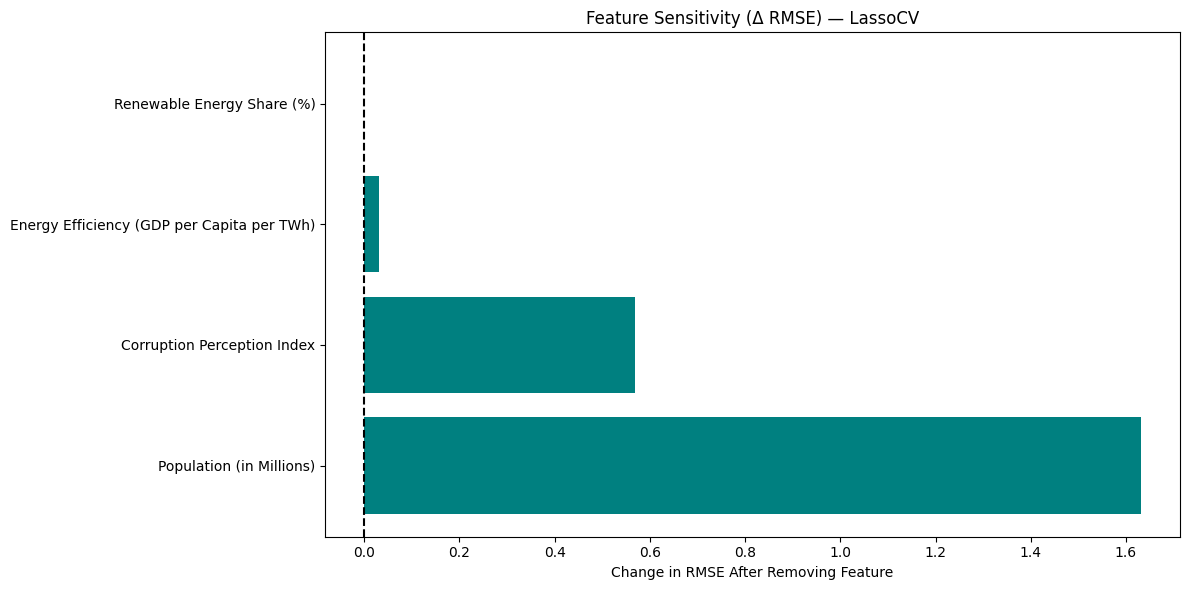


=== 🔍 Sensitivity Analysis: ElasticNet ===
🔹 Base Performance — RMSE: 1.8118 | MAE: 1.4608 | R²: 0.8811



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
2,Population (in Millions),1.628554,1.148500,-0.309890
3,Corruption Perception Index,0.566140,0.637709,-0.085936
0,Energy Efficiency (GDP per Capita per TWh),0.029944,0.021261,-0.003964
1,Renewable Energy Share (%),-0.000223,0.041935,0.000029


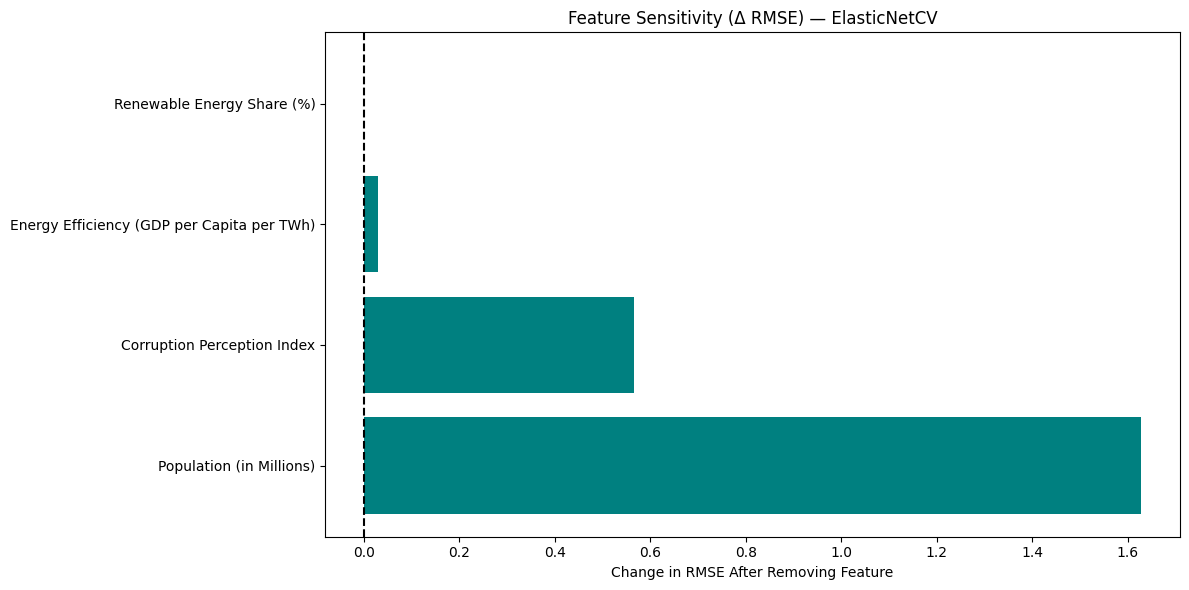


=== 🔍 Sensitivity Analysis: DecisionTree ===
🔹 Base Performance — RMSE: 0.4098 | MAE: 0.3156 | R²: 0.9939



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
1,Renewable Energy Share (%),1.251672,0.733117,-0.093926
2,Population (in Millions),0.131620,0.086179,-0.004536
3,Corruption Perception Index,0.006491,-0.005649,-0.000194
0,Energy Efficiency (GDP per Capita per TWh),-0.004801,-0.004535,0.000142


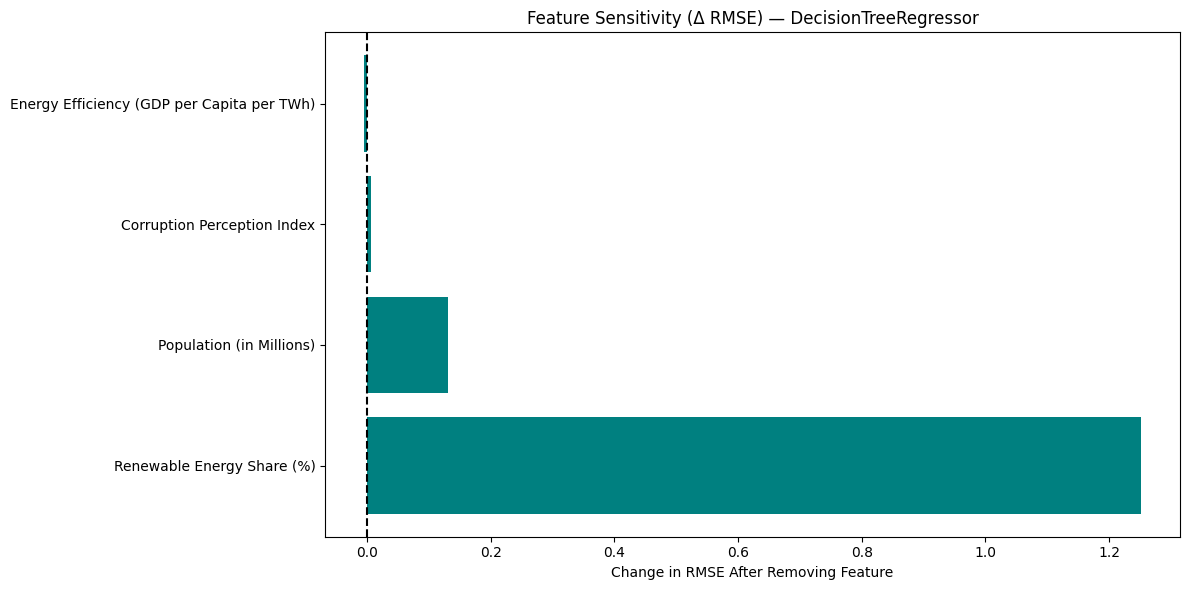


=== 🔍 Sensitivity Analysis: RandomForest ===
🔹 Base Performance — RMSE: 0.3662 | MAE: 0.2815 | R²: 0.9951



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
1,Renewable Energy Share (%),0.882034,0.586251,-0.051591
2,Population (in Millions),0.099792,0.076631,-0.003009
3,Corruption Perception Index,0.010671,0.009542,-0.000287
0,Energy Efficiency (GDP per Capita per TWh),-0.005334,-0.023526,0.000141


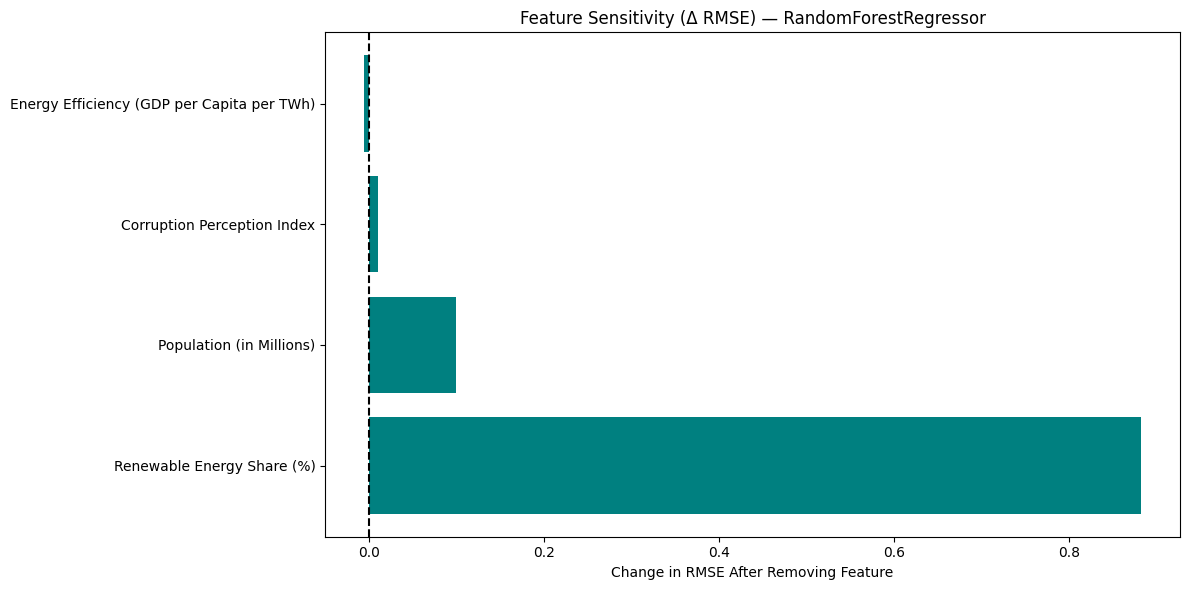


=== 🔍 Sensitivity Analysis: XGBoost ===
🔹 Base Performance — RMSE: 0.6979 | MAE: 0.5235 | R²: 0.9824



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
1,Renewable Energy Share (%),0.945114,0.530691,-0.080157
0,Energy Efficiency (GDP per Capita per TWh),-0.109151,-0.095905,0.005088
3,Corruption Perception Index,0.084557,0.031624,-0.004535
2,Population (in Millions),-0.043431,-0.050952,0.002128


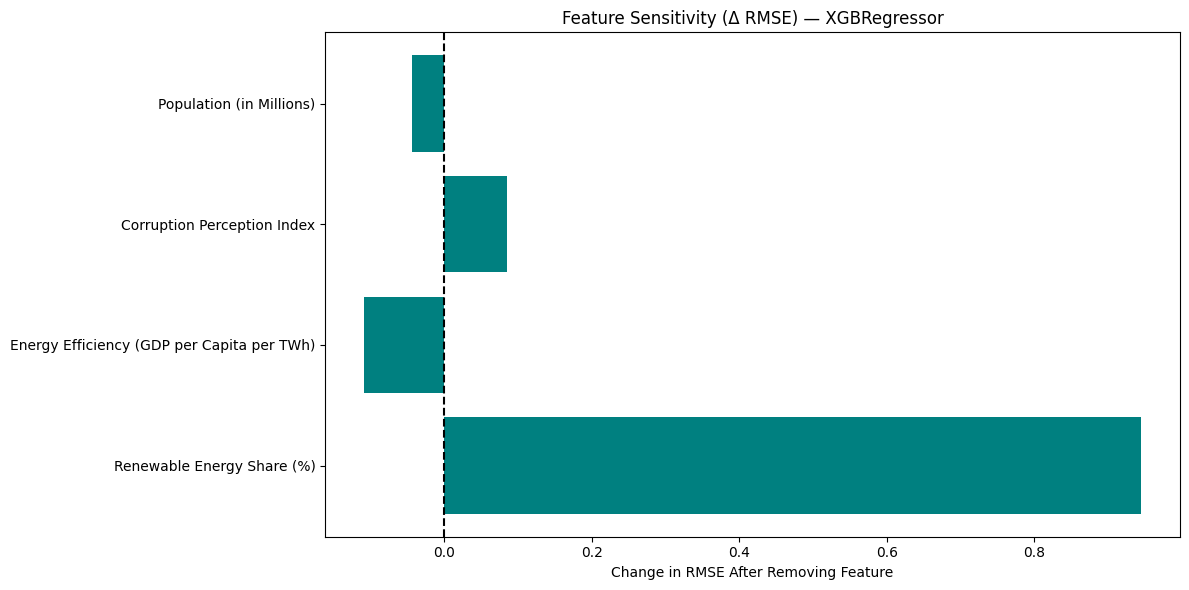


=== 🔍 Sensitivity Analysis: AdaBoost ===
🔹 Base Performance — RMSE: 0.3698 | MAE: 0.2821 | R²: 0.9950



,Feature Removed,Δ RMSE,Δ MAE,Δ R²
1,Renewable Energy Share (%),0.920849,0.607031,-0.055397
2,Population (in Millions),0.126361,0.090807,-0.003964
0,Energy Efficiency (GDP per Capita per TWh),0.025476,0.028488,-0.000706
3,Corruption Perception Index,0.001402,-0.020503,-0.000038


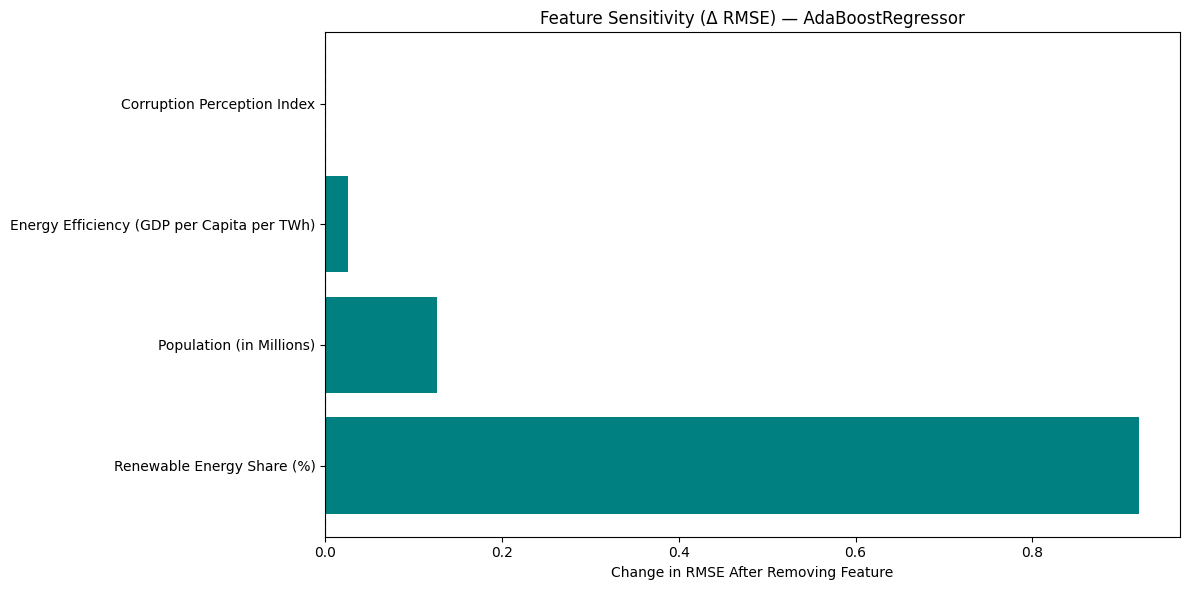

In [22]:
models = {
    'Lasso': lasso_cv,
    'ElasticNet': elastic_net_cv,
    'DecisionTree': tree,
    'RandomForest': rf,
    'XGBoost': xgb_reg,
    'AdaBoost': ada
}

# Drop non-numeric column from training and testing sets
X_train_numeric = X_train.drop(columns=['Country']) if 'Country' in X_train.columns else X_train
X_test_numeric = X_test.drop(columns=['Country']) if 'Country' in X_test.columns else X_test

# ======= Performance Metrics Function =======
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# ======= Sensitivity Analysis Function =======
def sensitivity_analysis(model, X_train, X_test, y_train, y_test):
    base_model = clone(model)
    base_model.fit(X_train, y_train)

    base_rmse, base_mae, base_r2 = evaluate_model(base_model, X_test, y_test)
    print(f"🔹 Base Performance — RMSE: {base_rmse:.4f} | MAE: {base_mae:.4f} | R²: {base_r2:.4f}\n")

    results = []

    for col in X_train.columns:
        X_train_temp = X_train.drop(columns=[col])
        X_test_temp = X_test.drop(columns=[col])

        temp_model = clone(model)
        temp_model.fit(X_train_temp, y_train)
        rmse, mae, r2 = evaluate_model(temp_model, X_test_temp, y_test)

        results.append({
            'Feature Removed': col,
            'Δ RMSE': rmse - base_rmse,
            'Δ MAE': mae - base_mae,
            'Δ R²': r2 - base_r2
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Δ RMSE', key=abs, ascending=False)

    display(results_df)

    #  bar chart of most impactful features
    plt.figure(figsize=(12, 6))
    plt.barh(results_df['Feature Removed'], results_df['Δ RMSE'], color='teal')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f'Feature Sensitivity (Δ RMSE) — {model.__class__.__name__}')
    plt.xlabel('Change in RMSE After Removing Feature')
    plt.tight_layout()
    plt.show()

# ======= Run Sensitivity Analysis for Each Model =======
for name, model in models.items():
    print(f"\n=== 🔍 Sensitivity Analysis: {name} ===")
    sensitivity_analysis(model, X_train_numeric, X_test_numeric, y_train, y_test)


The sensitivity analysis helps us understand which features are necessary to retain predictive performance. This is especially useful for policy-makers to prioritize interventions.

1. **Renewable Energy Share (%)**

Removing this variable led to the largest degradation in performance across tree-based models (Decision Tree, Random Forest, XGBoost, AdaBoost).

**Interpretation:** Countries with higher renewable shares tend to have lower emissions. This variable is critical for explaining CO₂ outcomes in models that capture non-linear patterns and interactions.

**Policy Implication:** Increasing renewable energy penetration has a direct and irreplaceable role in reducing per capita emissions.

2. **Population (in Millions)**

Caused significant performance drop in linear models (Lasso, ElasticNet), but was less critical in tree-based models.

**Interpretation:** Population levels relate to emissions linearly or through interactions with GDP, energy use, etc.

**Policy Implication:** While population size impacts total emissions, it's not indispensable for predicting per capita emissions when other variables are present.

3. **Corruption Perception Index**

Moderate sensitivity across models, especially in linear models.

**Interpretation:** Governance quality influences energy policy enforcement and infrastructure efficiency, but it’s not the dominant driver of emissions variation.

**Policy Implication:** Anti-corruption efforts matter but are indirect levers in emissions mitigation.

4. **Energy Efficiency (GDP per Capita per TWh)**

Despite being prominent in SHAP analysis, its removal had little effect on most models’ accuracy.

**Interpretation:** Its information may be encoded in other features (e.g., GDP, renewables, CPI). It influences model predictions, but models can approximate its effect via proxies.

**Policy Implication:** Energy efficiency is important but should be assessed in combination with other metrics like renewables and governance to evaluate its true impact.

**Therefore, models suggest that policies focusing on increasing the share of renewable energy offer would be the most direct and robust route to reducing CO₂ emissions per capita, more so than governance, population scaling, or energy efficiency alone.**

# **Conclusion**

This project highlights the effectiveness of machine learning techniques in uncovering the key drivers of CO₂ emissions per capita across diverse countries and time periods. Through rigorous model comparison and sensitivity analysis, decision tree regression stood out as the most accurate and interpretable approach, capable of capturing complex patterns within the data. This makes it a valuable tool for understanding the underlying factors influencing emission trends.

Importantly, the project’s findings contribute to the broader goal of forecasting progress toward carbon neutrality. By pinpointing key drivers and quantifying their impact on emissions, policymakers and stakeholders can design more targeted and effective strategies to reduce carbon footprints. The predictive capabilities of the decision tree regression model also offer a practical way to estimate when different countries might achieve carbon neutrality under current or adjusted conditions.

In summary, this work demonstrates that integrating machine learning with environmental data analysis offers a powerful framework to both explain and predict carbon emissions trends, paving the way for accelerated and evidence-based efforts toward a carbon-neutral future.
